# Computer Simulation Project
Simulating a discrete-event CPU scheduler.

**Authors**: <br>
Mohammadreza Mofayezi 98106059 <br>
Amirhossein Bagheri 98105621

## Import Libraries

In [239]:
from typing import List

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from queue import PriorityQueue

from scipy.stats import norm, expon, poisson

## Inputs
The parameters, number of processes and duration of simulation.

In [240]:
# parameters
X = 8
Y = 8
Z = 32
# number of processes
N = 100
# length of simulation
L = 800
# task threshold
K = 10
seed = 1234
T1 = 2
T2 = 4

In [241]:
np.random.seed(seed=seed)

## Job Creator

In [243]:
class Task:
    def __init__(self, id: int, X: int, Y: int, Z: int):
        self.id = id
        self.inter_arrival = int(poisson.rvs(X))
        self.service_time = int(expon.rvs(Y))
        self.time_out = int(expon.rvs(Z))
        self.remaining_service = self.service_time
        self.priority = self.get_priority()
        self.arrival_time = None
        self.finish = -1
        self.time_outed = False

    def get_priority(self):
        return np.random.choice([1, 2, 3], 1, p=[0.1, 0.2, 0.7])[0]

    def __eq__(self, __o: object) -> bool:
        return self.priority == __o.priority

    def __repr__(self) -> str:
        return f'Task {self.id} Priority: {self.priority} - InterArrival: {self.inter_arrival} - Arrival: {self.arrival_time} - ServiceTime: {self.service_time} FinishTime: {self.finish} SystemTime: {self.finish - self.arrival_time} WaitingTime: {self.finish - self.arrival_time - self.service_time} TimeOut: {self.time_out} TimeOuted: {self.time_outed}'


class JobCreator:
    def __init__(self, num_tasks: int):
        self.num_tasks = num_tasks
        self.tasks = PriorityQueue()
        self.all_tasks = []

    def run(self, X: int, Y: int, Z: int):
        start = 0
        task = Task(0, X, Y, Z)
        task.arrival_time = 0
        self.tasks.put((task.arrival_time, task.priority, -
                       task.remaining_service, task))
        self.all_tasks.append(task)

        for i in range(1, self.num_tasks):
            task = Task(i, X, Y, Z)
            start += task.inter_arrival
            task.arrival_time = start
            self.tasks.put((task.arrival_time, task.priority, -
                           task.remaining_service, task))
            self.all_tasks.append(task)

    def get_task(self, time: int):
        if self.tasks.queue[0][0] <= time:
            return self.tasks.get()[-1]
        return None

    def len(self):
        return len(self.tasks.queue)

    def len_arrived(self, time: int):
        return sum(1 for t in self.tasks.queue if t[-1].arrival_time <= time)

    def empty_job(self):
        return self.tasks.empty()


## Queues
First Come First Serve and Round Robin Queue.

In [244]:
class FCFS:
    def __init__(self):
        self.q = []

    def insert(self, task: Task):
        self.q.insert(0, task)

    def len(self):
        return len(self.q)

    def run(self):
        q = []
        for i in range(len(self.q)):
            if self.q[i].remaining_service > 0:
                q.append(self.q[i])
        self.q = q

    def get_task(self):
        return self.q[-1]

    def pop_task(self):
        return self.q.pop()

    def give_up(self, task: Task = None):
        return False

    def runtime(self):
        return float("inf")


class RR(FCFS):
    def __init__(self, T: int):
        super().__init__()
        self.T = T

    def give_up(self, task: Task = None):
        return task.remaining_service > self.T

    def runtime(self):
        return self.T


## Processor

In [245]:
class Processor:
    def __init__(self, num_tasks: int, max_simulation: int, queues: List, P: List, K: int, X: int, Y: int, Z: int):
        self.job_creator = JobCreator(num_tasks)
        self.job_creator.run(X, Y, Z)
        self.queues = queues
        self.simulation_time = 0
        self.max_simulation_time = max_simulation
        self.K = K
        self.order_of_finish = []
        self.P = P
        self.queue_lens_time = []
        self.queue_lens = [[] for _ in range(len(queues) + 1)]

    def job_loader(self, k: int):
        if sum([q.len() for q in self.queues]) >= k:
            return
        queue = PriorityQueue()
        for _ in range(k):
            if self.job_creator.empty_job():
                break
            task = self.job_creator.get_task(self.simulation_time)
            if task is None:
                break

            queue.put((task.priority, -task.remaining_service, task))

        for _ in range(len(queue.queue)):
            self.queues[0].insert(queue.get()[-1])

    def process(self, i: int):
        self.set_queue_lens()
        q = self.queues[i]
        task = q.get_task()
        give_up = q.give_up(task)
        time = min(q.runtime(), task.remaining_service)
        task.remaining_service = task.remaining_service - time
        self.simulation_time += time
        if task.remaining_service == 0:
            self.order_of_finish.append(task)
            task.finish = self.simulation_time
        q.run()
        if give_up:
            task = q.pop_task()
            self.queues[i+1].insert(task)
        self.queue_lens[-1].append(self.job_creator.len_arrived(self.simulation_time))
        self.job_loader(self.K)

    def queue_chooser(self):
        return np.random.choice(list(range(len(self.P))), 1, p=self.P)[0]

    def time_out(self):
        for q in self.queues:
            qq = []
            for i in range(q.len()):
                if self.simulation_time - q.q[i].arrival_time > q.q[i].time_out:
                    q.q[i].finish = self.simulation_time
                    q.q[i].time_outed = True
                    self.order_of_finish.append(q.q[i])
                else:
                    qq.append(q.q[i])
            q.q = qq

    def dispatcher(self):
        while (self.job_creator.len() > 0 or sum([q.len() for q in self.queues]) > 0) and self.simulation_time <= self.max_simulation_time:
            if sum([q.len() for q in self.queues]) > 0:
                choose = self.queue_chooser()
                if self.queues[choose].len() > 0:
                    self.process(choose)
            else:
                self.simulation_time += 1
                self.job_loader(self.K)
            self.time_out()

    def set_queue_lens(self):
        for i in range(len(self.queues)):
            self.queue_lens[i].append(self.queues[i].len())
        self.queue_lens_time.append(self.simulation_time)

    def run(self, verbose=False):
        self.set_queue_lens()
        self.queue_lens[-1].append(self.job_creator.len_arrived(self.simulation_time))
        self.job_loader(self.K)
        self.dispatcher()
        if verbose:
            print(f"Number of jobs done: {len(self.order_of_finish)}")
            for task in self.order_of_finish:
                print(task)

    def save_csv(self):
        pass



In [246]:
np.random.seed(seed=11)
processor = Processor(N, L, [RR(T1), RR(T2), FCFS()], [0.8, 0.1, 0.1], K=K, X=X, Y=Y, Z=Z)
processor.run(verbose=True)


Number of jobs done: 92
Task 0 Priority: 3 - InterArrival: 5 - Arrival: 0 - ServiceTime: 8 FinishTime: 8 SystemTime: 8 WaitingTime: 0 TimeOut: 32 TimeOuted: False
Task 1 Priority: 2 - InterArrival: 7 - Arrival: 7 - ServiceTime: 8 FinishTime: 18 SystemTime: 11 WaitingTime: 3 TimeOut: 32 TimeOuted: False
Task 2 Priority: 3 - InterArrival: 7 - Arrival: 14 - ServiceTime: 8 FinishTime: 24 SystemTime: 10 WaitingTime: 2 TimeOut: 32 TimeOuted: False
Task 3 Priority: 1 - InterArrival: 10 - Arrival: 24 - ServiceTime: 8 FinishTime: 32 SystemTime: 8 WaitingTime: 0 TimeOut: 32 TimeOuted: False
Task 4 Priority: 2 - InterArrival: 10 - Arrival: 34 - ServiceTime: 8 FinishTime: 42 SystemTime: 8 WaitingTime: 0 TimeOut: 33 TimeOuted: False
Task 5 Priority: 1 - InterArrival: 16 - Arrival: 50 - ServiceTime: 8 FinishTime: 58 SystemTime: 8 WaitingTime: 0 TimeOut: 32 TimeOuted: False
Task 6 Priority: 3 - InterArrival: 13 - Arrival: 63 - ServiceTime: 9 FinishTime: 72 SystemTime: 9 WaitingTime: 0 TimeOut: 32 Tim

## Results

In [254]:
inputs = [{'X': 8, 'Y': 8, 'Z': 32, 'N': 100, 'L': 800, 'K': 10, 'T1': 2, 'T2': 4},
          {'X': 8, 'Y': 4, 'Z': 32, 'N': 50, 'L': 800, 'K': 10, 'T1': 2, 'T2': 4},
          {'X': 8, 'Y': 8, 'Z': 16, 'N': 100, 'L': 800, 'K': 10, 'T1': 2, 'T2': 4},
          {'X': 8, 'Y': 8, 'Z': 32, 'N': 100, 'L': 800, 'K': 10, 'T1': 6, 'T2': 8}]


In [251]:
def get_input_name(inp):
    return str(inp)[1:-1].replace("'", "").replace(": ", "-").replace(", ", "-")


def run_and_plot(input_i, plot_func, save=False):
    np.random.seed(seed=seed)
    processor = Processor(input_i['N'], input_i['L'], [RR(input_i['T1']), RR(input_i['T2']), FCFS()], [0.8, 0.1, 0.1],
                          K=input_i['K'], X=input_i['X'], Y=input_i['Y'], Z=input_i['Z'])
    processor.run(verbose=False)
    print(f"Number of jobs done: {len(processor.order_of_finish)}")
    plot_func(processor, save, get_input_name(input_i))


### Length of Queues

In [252]:
def plot_queue_lens(processor, save=False, input_name='default'):
    fig, ax = plt.subplots()
    print(input_name)
    for i in range(4):
        print(f'Average of length {queue_names[i]}: {np.mean(processor.queue_lens[i])}')
        ax.plot(processor.queue_lens_time,processor.queue_lens[i], label=queue_names[i])
    ax.legend()
    ax.set_yticks([i for i in range(np.max(processor.queue_lens) + 1)])
    ax.set_title('Length of queues during simulation time')
    plt.show()
    if save:
        fig.savefig(f'figs/queue-len-{input_name}.png')


Number of jobs done: 99
X-8-Y-8-Z-32-N-100-L-800-K-10-T1-2-T2-4
Average of length Round-Robin-T1: 0.4121863799283154
Average of length Round-Robin-T2: 1.3870967741935485
Average of length FCFS: 1.043010752688172
Average of length Priority Queue: 0.33691756272401435


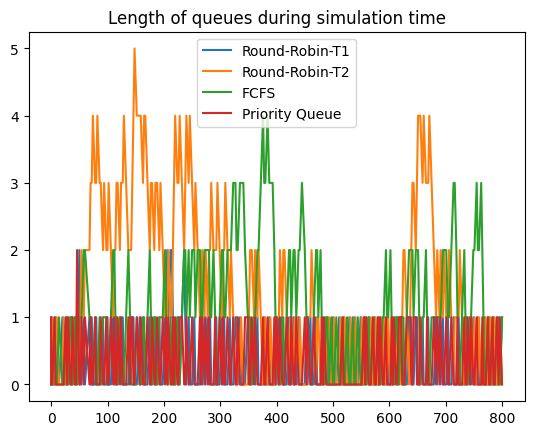

Number of jobs done: 50
X-8-Y-4-Z-32-N-50-L-800-K-10-T1-2-T2-4
Average of length Round-Robin-T1: 0.49038461538461536
Average of length Round-Robin-T2: 0.5
Average of length FCFS: 0.04807692307692308
Average of length Priority Queue: 0.09615384615384616


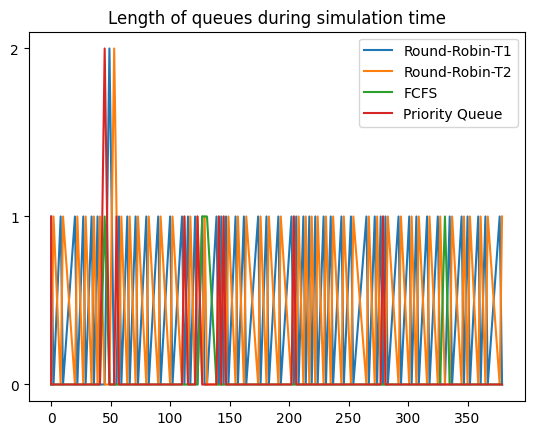

Number of jobs done: 98
X-8-Y-8-Z-16-N-100-L-800-K-10-T1-2-T2-4
Average of length Round-Robin-T1: 0.40293040293040294
Average of length Round-Robin-T2: 0.6556776556776557
Average of length FCFS: 0.6043956043956044
Average of length Priority Queue: 0.31135531135531136


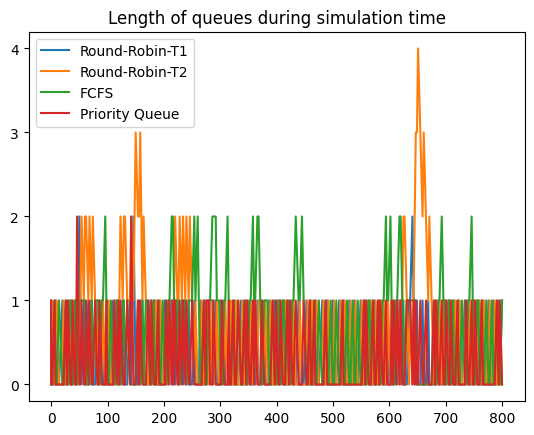

Number of jobs done: 98
X-8-Y-8-Z-32-N-100-L-800-K-10-T1-6-T2-8
Average of length Round-Robin-T1: 0.6460674157303371
Average of length Round-Robin-T2: 2.1292134831460676
Average of length FCFS: 0.0
Average of length Priority Queue: 0.5112359550561798


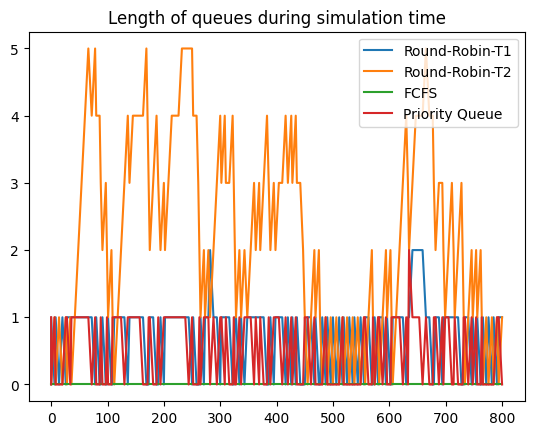

In [255]:
queue_names = ['Round-Robin-T1', 'Round-Robin-T2', 'FCFS', 'Priority Queue']
seed = 1111
for i in inputs:
    run_and_plot(i, plot_queue_lens, save=False)

### Time Spent in Queues